# Machine Learning, AI and Optimization Project
## Project Title: *To bee or not to bee* 🐝 

### Courses
- IG.2412 (Machine Learning)
- IG.2411 (AI and Optimization)

> This project is shared across both courses. Follow only the parts relevant to the course(s) you're enrolled in.

---

## I. Project Overview
**Goal**: Detect and classify bees and bumblebees from other insects using a dataset of 347 high-resolution images.

- **Images 1–250**: Provided with segmentation masks and labels (`bug type` and `species`)

<span style="color:green"> Dataset is stored in the `data` dir: `../data` to access from `work` dir  </span>
- **Images 251–347**: Provided only with segmentation masks (for final evaluation)

---

## II. Expected Deliverables (Due:  June 2nd, 2025 at 12:30 PM)

### 1. Report (PDF)
- Description of extracted features
- Algorithms and methods used
- Visualizations and interpretations

### 2. CSV File (Results)
- Columns: `"ID"`, `"bug type"`
- Predictions on test images (251–347) using your best model

---

## III. Tasks Breakdown

### III.1 Feature Extraction [7 points]
Extract the following from training data:
- Shape & symmetry features (from provided Jupyter Notebook) [IG.2411]
- Pixel ratio: bug pixels / total image pixels
- RGB statistics inside bug mask:
  - Min, Max, Mean [IG.2412]
  - Median, Std Deviation [IG.2412]
- Two or more **custom features** (can be inside or outside mask)

---

### III.2 Data Visualization [5 points] 

<span style="color:green"> cf. IG.2412, Week 12-13 slides </span>

Include and comment on:
- Class distribution plots (`bug type` and `species`)
- PCA projection (2D)
- Two or more **non-linear projections** (e.g.,MDS, ISOMAP, LLE, t-SNE, etc. ) [IG.2412]

---

### III.3 Machine Learning & Deep Learning    [6 + 2 points] 

<span style="color:green"> cf. IG.2412, Classification - Weeks 6,7,9,11 slides; Clustering - Weeks 15,16,18 slides </span>

**Required Models:**
- 2 supervised, non-DL, non-ensemble methods (<span style="color:green"> cf. IG.2412, Lecture 1-3 </span>) [IG.2412]
- 1 ensemble supervised method (<span style="color:green"> cf. IG.2412, Lecture 4 </span>) [IG.2412]
- 2 clustering methods (<span style="color:green"> cf. IG.2412, Lecture 6,7 </span>) [IG.2412]
- 1 supervised method with hyperparameter tuning (Grid/Randomized Search) [IG.2411]

**Evaluation:**
- Apply best model on test images (251–347)
- Submit predictions in CSV format

**Optional (Extra Credit):**
- Up to 2 supervised DL models trained on raw images
- Up to 2 models predicting `species` instead of just `bug type`

---

## Tips
- Use quality metrics to evaluate each model.
- Justify your choice of features and models.
- Keep your report clear and reproducible.


In [ ]:
# Feature extraction and data treatment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import measure
import os
import re


In [ ]:
# bibliothèque pour la partie projection des données
from sklearn.manifold import TSNE
import umap

# bibliothèque pour la partie clustering
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
def extract_numbers(filename):
    # Use regex to find all numbers in the filename
    match = re.findall(r'\d+', filename)
    if match:
        return int(match[0])
    else:
        return -1

img_path = 'train/images/'
mask_path = 'train/masks/'



images = sorted([f for f in os.listdir(img_path) if f.endswith('.JPG')],
                key=lambda f: extract_numbers(f)) 
masks = sorted([f for f in os.listdir(mask_path) if f.endswith('.tif')],
               key=lambda f: extract_numbers(f))
#print(f"Sorted images: {images[:10]}")  # Affiche les 10 premières images triées
#print(f"Sorted masks: {masks[:10]}")

image_numbers = sorted([extract_numbers(f) for f in images])
mask_numbers = sorted([extract_numbers(f) for f in masks])

missing_mask_numbers = set(image_numbers) - set(mask_numbers)
missing_image_numbers = set(mask_numbers) - set(image_numbers)

if missing_mask_numbers:
    print("Image(s) sans masque correspondant :", missing_mask_numbers)
    print("Nom(s) de fichier image concerné(s) :")
    for img in images:
        if extract_numbers(img) in missing_mask_numbers:
            print("  -", img)

if missing_image_numbers:
    print("Masque(s) sans image correspondante :", missing_image_numbers)
    print("Nom(s) de fichier masque concerné(s) :")
    for mask in masks:
        if extract_numbers(mask) in missing_image_numbers:
            print("  -", mask)

if 154 in image_numbers:
    image_numbers.remove(154)
    # Supprimer l'image correspondante de images
    images = [img for img in images if extract_numbers(img) != 154]
    # Supprimer aussi le masque correspondant si nécessaire
    masks = [mask for mask in masks if extract_numbers(mask) != 154]

print("Image numbers:", len(image_numbers))
print("Mask numbers:", len(mask_numbers))

In [ ]:
features = []
if len(image_numbers) != len(mask_numbers):
    print(f"Warning: Number of images ({len(images)}) does not match number of masks ({len(masks)})")

min_length = min(len(images), len(masks))


for i in range (min_length):
    # Extract features from the image and mask
    #print(f"Processing image: {image}")
    #print(f"Processing mask: {mask}")

    img = cv2.imread(os.path.join(img_path, images[i]))
    mask_img = cv2.imread(os.path.join(mask_path, masks[i]), 0)


    if img is None:
        print(f"Error loading image: {images[i]}")
        continue  # Passer à l'image suivante

    if mask_img is None:
        print(f"Error loading mask: {mask[i]}")
        continue  # Passer à l'image suivante

    shappe_img = img.shape
    shappe_mask = mask_img.shape

    if shappe_img[0] != shappe_mask[0] or shappe_img[1] != shappe_mask[1]:
        mask = cv2.resize(mask_img, (shappe_img[1], shappe_img[0]), interpolation=cv2.INTER_NEAREST)

    ratio = mask_img.sum() / (shappe_mask[0] * shappe_mask[1])

    bug_Area = img[mask_img >0]
    if bug_Area.size == 0:  
        print(f"No bug area detected in mask: {mask}")
        continue

    r, g, b = bug_Area[:, 0], bug_Area[:, 1], bug_Area[:, 2]
    bug_Area_size= np.count_nonzero(mask_img)

    rgb_features = {"r_min": r.min(),"r_max": r.max(), "r_mean": r.mean(),"r_median":np.median(r), "r_std": r.std(),
                    "g_min": g.min(),"g_max": g.max(), "g_mean": g.mean(), "g_median":np.median(g),"g_std": g.std(),
                    "b_min": b.min(),"b_max": b.max(), "b_mean": b.mean(), "b_median":np.median(b),"b_std": b.std()}
    
    contours = measure.find_contours(mask_img, 0.5)
    valid_contours = [c for c in contours if len(c) >= 3]

    if valid_contours:
        contour = max(valid_contours, key=lambda c: cv2.contourArea(np.array(c, dtype=np.float32)))
        contour  = np.array(contour.astype(np.float32))

        contour_area = cv2.contourArea(contour)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)

        convex_ratio = contour_area / hull_area if hull_area > 0 else 0
        excentricity = contour_area / (np.pi * (bug_Area_size / np.pi) ** 2) if bug_Area_size > 0 else 0
    else:
        convex_ratio = 0
        exentricity = 0

In [ ]:
all_features = {
        "img_name": images[i],
        "mask_name": masks[i],
        "img_shape_0": shappe_img[0],
        "img_shape_1": shappe_img[1],
        "mask_shape_0": shappe_mask[0],
        "mask_shape_1": shappe_mask[1],
        "ratio": ratio,
        "convex_ratio": convex_ratio,
        "exentricity": excentricity
    }

all_features.update(rgb_features)
features.append(all_features)

features_df = pd.DataFrame(features)

features_df.to_csv('features.csv', index=False)
features_df.to_excel("features.xlsx", index=False)

================ II. Maintenant qu'on a extrait les features, on peut visualiser les données ==============

================= Répartition des types d'insectes et des espèces ====================

In [ ]:
df_class = pd.read_excel("train/classif.xlsx")
print("df_class.shape:", df_class.shape)
df_class = df_class[df_class['ID'] != 154]
print("df_class.shape:", df_class.shape)

bug_type_count = df_class['bug type'].value_counts()
print("bug_type_count:", bug_type_count)

plt.figure(figsize=(10, 6))
bug_type_count.plot(kind='bar', color='skyblue')
plt.title("Répartition des types d'insectes")
plt.xlabel('Espèce')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

species_count = df_class['species'].value_counts()

plt.figure(figsize=(10, 6))
species_count.plot(kind='bar', color='salmon')
plt.title('Répartition des espèces')
plt.xlabel('Espèce')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

========== Ici On effectue une projection PCA sur les features extraites =============

In [ ]:
numeric_df = features_df.select_dtypes(include=[np.number])

def variances(df):
    variances = df.var()
    return variances

vars = variances(numeric_df)

def standardize_data(df):
    return (df - df.mean()) / df.std()

standardized_df = standardize_data(numeric_df)

centered_data = standardized_df

def covariance_matrix(df):
    nb_col = df.shape[1]
    cov_matrix = np.zeros((nb_col, nb_col))
    for i in range(nb_col):
        for j in range(nb_col):
            cov_matrix[i][j] = df.iloc[:, i].cov(df.iloc[:, j])
    return cov_matrix

cov_matrix = covariance_matrix(centered_data)

def eigen_decomposition(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = eigen_decomposition(cov_matrix)

def sort_eigenvalues(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_values = eigenvalues[sorted_indices]
    sorted_vectors = eigenvectors[:, sorted_indices]
    return sorted_values, sorted_vectors

sorted_eigenvalues, sorted_eigenvectors = sort_eigenvalues(eigenvalues, eigenvectors)


In [ ]:
def select_principal_components(eigenvalues, eigenvectors, k):
    select_eigenvalues = eigenvalues[:k]
    select_eigenvectors = eigenvectors[:, :k]
    return select_eigenvalues, select_eigenvectors

selected_values, selected_vectors = select_principal_components(sorted_eigenvalues, sorted_eigenvectors, 2)

def project_data(df, eigenvectors):
    return np.dot(df.values, eigenvectors)

projected_data = project_data(centered_data, selected_vectors)
print("projected_data.shape:", projected_data.shape)
#df_class = df_class.reset_index(drop=True)


def plot_pca(projected_data, df_class):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=projected_data[:, 0], y=projected_data[:, 1], hue=df_class['bug type'], palette='Set1')
    plt.title('PCA Projection of Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Bug Type')
    plt.show()
    
plot_pca(projected_data, df_class)

In [ ]:
K  = 6
kmeans = KMeans(n_clusters=K, random_state=42)
clusters = kmeans.fit_predict(projected_data)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=clusters, cmap='tab10', s=30)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection with K-means Clusters")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

=========== Maintenant qu'on a réalisé le pca, on va explorer une autre méthode de projection ==========

========== On va utiliser t-SNE pour projeter les données dans un espace 2D ==========

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_projected = tsne.fit_transform(numeric_df)

tsne_df = pd.DataFrame({
    't-SNE 1': tsne_projected[:, 0],
    't-SNE 2': tsne_projected[:, 1],
    'bug type': df_class['bug type'].values
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x='t-SNE 1',
    y='t-SNE 2',
    hue='bug type',
    palette='Set1',
    alpha=0.7,
    edgecolor='k'
)

plt.title("t-SNE projection of features by bug type")
plt.xlabel("t-SNE 1 (no unit)")
plt.ylabel("t-SNE 2 (no unit)")
plt.legend(title="Bug Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


========== On va maintenant essayer d'utiliser UMAP pour projeter les données dans un espace 2D ==========

In [ ]:
reducer = umap.UMAP(random_state=0)
umap_projected = reducer.fit_transform(numeric_df)

umap_df = pd.DataFrame({
    'UMAP 1': umap_projected[:, 0],
    'UMAP 2': umap_projected[:, 1],
    'bug type': df_class['bug type'].values
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=umap_df,
    x='UMAP 1',
    y='UMAP 2',
    hue='bug type',
    palette='Set2',
    alpha=0.8,
    edgecolor='k'
)

plt.title("UMAP projection of features by bug type")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Bug Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

========== Dans cette partie on va faire un clustering sur les données projetées ==========

1. KMeans Clustering

In [ ]:
X, y = projected_data , df_class['bug type'].values

kmeans = KMeans(n_clusters =bug_type_count.shape[0], random_state=42)
clusters = kmeans.fit_predict(X)

X_with_clusters = X.copy()
X_with_clusters = np.column_stack((X_with_clusters, clusters))

X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

accuracy = log_reg.score(X_test, y_test)
print(f"Accuracy of Logistic Regression on KMeans clusters: {accuracy:.2f}")

score = silhouette_score(X_with_clusters, clusters) # sert à mesurer la cohérence des clusters
print(f"Silhouette Score: {score:.2f}") # plus il est proche de 1, mieux c'est

# Pour les résultats : plus de chevauchement entre les clusters pour X = projected_data donc score faible
# Groupes bien séparés pour X = umap_projected donc score élevé

2. DBSCAN Clustering

In [ ]:
X = projected_data
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels = clusterer.fit_predict(X)

score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.2f}") 

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"HDBSCAN → Clusters: {n_clusters}, Silhouette Score: {score:.2f}")

## Supervised method - IA 


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

features_df = pd.read_csv("features.csv")
labels_df = pd.read_excel("train/classif.xlsx")

labels_df = labels_df[labels_df["ID"] != 154] # pas de 154 donc supprimer 
features_df["ID"] = features_df["img_name"].str.extract(r'(\d+)').astype(int) #estrait des nuemros d'images
merged_df = pd.merge(features_df, labels_df, on="ID") #fusion des features et labels ID 

value_counts = merged_df['bug type'].value_counts() #supprimer les classes rares, en dessous de 5 modèles
classes_to_keep = value_counts[value_counts >= 5].index
filtered_df = merged_df[merged_df['bug type'].isin(classes_to_keep)]

X = filtered_df.select_dtypes(include=[np.number]).drop(columns=["ID"]) # séparer les features X et les labels y
y = filtered_df["bug type"]

print("Nb exemples :", X.shape[0]) # infos du dataset 
print("Nb features :", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # on découpe le dataset en train/test
svm = SVC() # modèle SVM

param_grid = { # la grille d’hyperparamètres à tester
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
print("La recherche par grille") # recherche des meilleurs hyperparamètres via validation croisée
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nRésultats du Gridsearch :") # les résulstats de la recherche
print("Meilleurs paramètres:", grid_search.best_params_)
print("Score moyen en validation croisée:", grid_search.best_score_)

y_pred = grid_search.predict(X_test) # prédiction sur le jeu de test
acc = accuracy_score(y_test, y_pred) # score d'accuracy

print("\nÉvaluation finale sur le jeu de test:") # les performances finales 
print(f"Exactitude: {acc*100:.2f}%")
print("Classification détaillée:")
print(classification_report(y_test, y_pred))


Nb exemples : 248
Nb features : 21
La recherche par grille

Résultats du Gridsearch :
Meilleurs paramètres: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Score moyen en validation croisée: 0.7328205128205127

Évaluation finale sur le jeu de test:
Exactitude: 68.00%
Classification détaillée:
              precision    recall  f1-score   support

         Bee       0.77      0.79      0.78        29
   Bumblebee       0.65      0.73      0.69        15
   Butterfly       0.00      0.00      0.00         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.68        50
   macro avg       0.28      0.31      0.29        50
weighted avg       0.64      0.68      0.66        50



C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

Le SVM linéaire avec c=0.1 est celui qui a obtenu le meilleur score (~68 % de précision moyenne sur les 5 plis).

Le modèle est relativement bon pour les classes majoritaires. Aussi, on peut remarquer que le modèle ne prédit pas du tout certaines classes rares, car elles sont très peu représentées (les Hover fly et wasp par exemple).On voit que le modèle SVM entraîné avec GridSearchCV a une précision de 68 % sur ce jeu de test.
Pour conclure, ce modèle pose problème pour les classes très peu représentées (comme Wasp ou Hover fly), elles sont ignorées par le modèle. On peut le voir en évidence dans la matrice de confusion en dessous.
Cela met en évidence l'importance de l'équilibrage des classes dans l'apprentissage supervisé.

<Figure size 800x600 with 0 Axes>

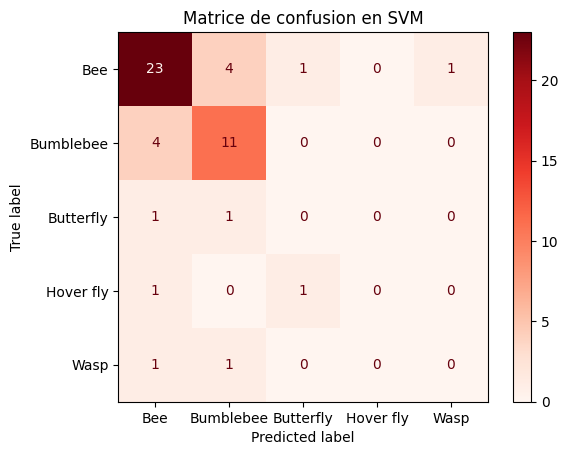

In [ ]:
#===================Matrice de confusion======================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#matrice de confusion 
cm = confusion_matrix(y_test, y_pred, labels=grid_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)

#on plot "
plt.figure(figsize=(8, 6))
disp.plot(cmap="Reds", values_format='d')
plt.title("Matrice de confusion en SVM")
plt.grid(False)
plt.show()

## Deep Learning method with hyperparameters and optimizers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim

df = pd.read_csv("features.csv")
np.random.seed(42) #on génère des labels factices aléatoires pour 249 lignes
df["bug_type"] = np.random.choice(["bee", "bumblebee", "other"], size=len(df))

X = df.drop(columns=["img_name", "mask_name", "bug_type"]) # on spéare X et y 
y = df["bug_type"]

scaler = StandardScaler()# normalisation des features
X_scaled = scaler.fit_transform(X)
le = LabelEncoder() # encodage des labels
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split( # on découpe le dataset en train/test
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

#conversion tensors pour PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class SimpleNN(nn.Module): #creation de classe de réseau de neurones simple
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleNN(X_train.shape[1], len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#on lance l'entrainement 
for epoch in range(30):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad(): # rapport évaluation 
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("Classification Report:")
    print(classification_report(y_test_tensor, predicted, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

         bee       0.12      0.12      0.12        16
   bumblebee       0.40      0.50      0.44        16
       other       0.54      0.39      0.45        18

    accuracy                           0.34        50
   macro avg       0.35      0.34      0.34        50
weighted avg       0.36      0.34      0.34        50



# Deep learning methode - Réseau de neurones simple

Plutôt que de travailler directement à partir des images, ont utilise les caractéristiques de l'image (forme, couleur, proportions) afin de limiter la complexité et de rendre le modèle plus léger et rapide à entraîner. Le modèle choisi est un réseau de neurones multicouche simple, entraîné grâce à la bibliothèque PyTorch. Il est composé de deux couches cachées utilisant la fonction d’activation ReLU, ce qui permet de capturer des relations non linéaires entre les différentes caractéristiques. La couche de sortie produit une prédiction parmi les différentes classes de type d’insectes.

L’apprentissage se fait sur des données préalablement normalisées grace à l’optimiseur Adam, qui ajuste les poids du réseau pour minimiser une fonction de perte adaptée à la classification multiclasse. Le réseau est entraîné pendant une trentaine d'epochs, pour ce volume de données c'est suffisant. Plus d'epochs n'aiderai pas.

Les résultats pour ce modèle atteignent une exactitude de 34 %, ce qui reste faible mais cohérent avec la taille limitée du jeu de données et la simplicité du réseau. La classe "other" est mieux reconnue (F1-score ≈ 0.45), tandis que les classes "bee" et "bumblebee" sont plus difficiles à distinguer (F1-scores plus faibles, autour de 0.12 et 0.44). Cela montre que le modèle capte certaines différences globales, mais peine à différencier des insectes visuellement proches.